# Forward UQ with Freq and Bayes from Parameter Estimation
# Not in Thesis!

In [ ]:
using Plots, DifferentialEquations, LaTeXStrings, KernelDensity, StatsBase, Distributions, ProgressMeter, FileIO, Interpolations

### Utilities

In [10]:
"""
Computes the gradient of the monod model.
    Inputs:
        - x: points where the gradient should be computed
        - q: input parameter
    Output:
        - ∇f: gradient of the monod model w.r.t. the input parameters
"""
function gradMonodModel(x,q)
    q₁, q₂ = q
    ∇f_q₁ = x./(q₂.+x)
    ∇f_q₂ = -(q₁.*x)./((q₂.+x).^2)
    ∇f = vcat(∇f_q₁,∇f_q₂)
end;

"""
Computes the confidence interval for the mean response
    Inputs:
        - x: point of the independend variable wherer the confidence interval will be computed
        - q: input parameters
        - σ: error variance
        - inv_𝒳ᵀ𝒳: term (𝒳ᵀ𝒳)⁻¹
        - t: value for the t-distribution
    Output:
        - bounds_conf: bounds of the confidence interval
"""
function getConfInterval(x, q, σ, inv_𝒳ᵀ𝒳, t)
    Y_x₀ = monod_fun(q,x) # estimate of the mean response
    ∇f = gradMonodModel(x,q) # gradient of the monod model
    lo_bound = Y_x₀ .- t*σ*sqrt(∇f'*inv_𝒳ᵀ𝒳*∇f)
    up_bound = Y_x₀ .+ t*σ*sqrt(∇f'*inv_𝒳ᵀ𝒳*∇f)
    hcat(lo_bound, up_bound)
end;

"""
Computest the prediction interval for new observations
    Inputs:
        - x: point of the independend variable wherer the confidence interval will be computed
        - q: input parameters
        - σ: error variance
        - inv_𝒳ᵀ𝒳: term (𝒳ᵀ𝒳)⁻¹
        - t: value for the t-distribution
    Output:
        - bounds_pred: bounds of the prediction interval
"""
function getPredictionInterval(x, q, σ, inv_𝒳ᵀ𝒳, t)
    Y_x₀ = monod_fun(q,x) # estimate of the mean response
    ∇f = gradMonodModel(x,q) # gradient of the monod model
    lo_bound = Y_x₀ .- t*σ*sqrt(1+∇f'*inv_𝒳ᵀ𝒳*∇f)
    up_bound = Y_x₀ .+ t*σ*sqrt(1+∇f'*inv_𝒳ᵀ𝒳*∇f)
    hcat(lo_bound, up_bound)
end;

"""
Function to determine the array elements within the credible interval

    Inputs:
        - dens: kde-density
        - vals: sampled values
        - lb_cred: lower bound credible interval
        - up_cred: upper bound credible interval

    Outputs: 
        - cred_elements: elements within the credible interval
""" 
function getCredElements(dens,vals,lb_cred,up_cred)
    # transform univariatekde in 2D array
    kde_dens = hcat(dens.x,dens.density)
    cred_elements = kde_dens[(lb_cred.<=kde_dens[:,1]).&(kde_dens[:,1].<=up_cred),:]
    cred_elements
end;

"""
Julia Type, that contains the information to plot the credible intervals
"""
struct CredIntervalStats
    x::Float64
    lb_cred::Float64
    up_cred::Float64
    kde::UnivariateKDE
    credElements::Array{Float64,2}
end;

"""
Return KDE estimate and the associated mean μ and standard deviation σ
    Inputs:
        - dist: array of realization of a random variable (e.g. QoI)
    Outputs:
        - μ: mean
        - σ: standard deviation
        - skew: skewness
        - kurtosis: kurtosis
"""
function getStatistics(dist)
    μ = round(StatsBase.mean(dist),digits=5)
    σ = round(StatsBase.std(dist),digits=5)
    skew = round(StatsBase.skewness(dist),digits=2)
    kurt = round(StatsBase.kurtosis(dist),digits=2)
    μ, σ, skew, kurt
end;

"""
Get the percentage of realizations for the QoIs within the credible intervals
    Inputs:
        - lb_cred: lower bound credible interval
        - up_cred: upper bound credible interval
        - vals: 
    Outputs:
        - counter: Number of model solutions within the credible interval
"""
function countPercentageInCred(lb_cred, up_cred, vals)
    counter = 0
    for i in 1:length(vals)::Int
        if (lb_cred < vals[i]) &&(vals[i] < up_cred)
            counter += 1 
        end
    end
    round(counter/length(vals), digits=3)
end;

# Uncertainty Propagation using information about the input uncetainties obtained by the frequentistic or bayesian parameter estimation approach
We utizlize the model and the results from example 4.1 (i.e. 01-Parameter-Estimation.ipynb)
## Monod model
Recall that we synthetically generated measurement data

\begin{align}
    \Upsilon_i  &= q_1\frac{x_i}{q_2+x_i} + \epsilon_i
\end{align}

where $\epsilon_i$ is assmumed to be i.i.d. and normal distributed.
In order to numerically generate synthetic data, we used $q_{1_0} = 0.146$ and $q_{2_0}=49.1$ and added measurement noise $\epsilon \sim \mathcal{N}\left(0,\sigma^2_0\right)$, where $\sigma_0=0.01$.

In [11]:
# Monod model function
function monod_fun(q,x)
    q₁,q₂=q
    y = (q₁.*x)./(q₂.+x)
end;

First we load the synthetically generated data from example 4.1.

In [12]:
data = load("..//02-Parameter-Estimation//data//measurement_data_100.jld2");
x, y_obs, y_model, ϵ, n = data["x"], data["y_obs"],data["y_model"], data["eps"], data["n"];

Plot the syntheticall generated measurement data.

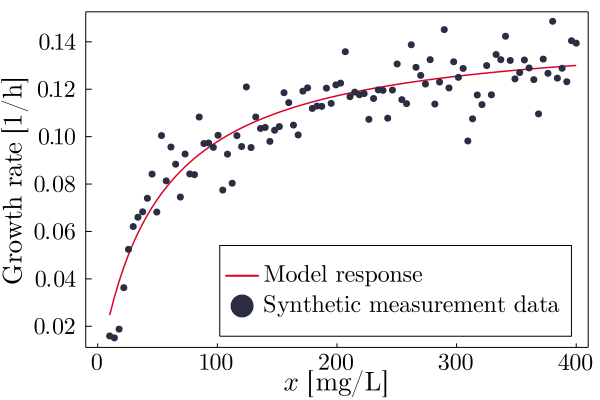

In [13]:
fontsize_tick=16
fontsize_legend=16
fonsize_label = 18
fonsize_titel = 20
# yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
p1 = plot(x,y_model;lc=colorant"#d90429",legend=:bottomright,label=L"\textrm{Model response}",legendfontsize=fontsize_legend,lw=1.5)
p1 = scatter!(x,y_obs;label=L"\textrm{Synthetic measurement data}",xlabel=L"x\;\,[\mathrm{mg}/\mathrm{L}]",ylabel=L"\textrm{Growth rate}\;\,[1/\mathrm{h}]",
        markercolor=colorant"#2b2d42", markerstrokecolor=colorant"#2b2d42",
        xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,grid=:none,
        xlim=(-10,410),
        yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,framestyle=:box,
        xticks = ([0,100,200,300,400],[L"0",L"100",L"200",L"300",L"400"]),
        yticks = ([0.02,0.04,0.06,0.08,0.1,0.12,0.14],[L"0.02",L"0.04", L"0.06",L"0.08",L"0.10",L"0.12",L"0.14"])
)
p1

## Uncertainty Quantification of the model response using the information about the input uncertainties obtained by frequentistic parameter estimation
First we load the statistics obtained with the frequentistic parameter estimation approach.

In [14]:
data = load("..//02-Parameter-Estimation//data//data-forward-UQ-freq.jld2");
q_OLS, σ²_OLS, X_OLS = data["q_OLS"], data["σ²_OLS"], data["X_OLS"];

$\hat{\Upsilon}_{x_0}$ is the estimate of the fixed but unknown mean response $\mathrm{E}[\Upsilon_{x_0}]$, where $x_0$ denotes a point in the domain of the independent variable $x$ which was not used to obtain an estimate $q_{\mathrm{OLS}}$ for the true fixed but unknown parameters $q_0$. We construct the estimate for the independent variables $x_0$ of the mean response by using the point estimates $q_{1_{\mathrm{OLS}}}$ and $q_{2_{\mathrm{OLS}}}$ obtained by an ordinary least squares approach (OLS).

First we construct the **confidence interval** to predict the mean response $\mu_{x_0} = \mathrm{E}[\Upsilon_{x_0}]$, where $x_0$ denotes a point in the domain of the independent variable $x$ which was not used to obtain an estimate $q_{\mathrm{OLS}}$ for the true fixed but unknown parameters $q_0$. We refer to [Nonlinear Regression - pp. 192-193](http://www.ru.ac.bd/wp-content/uploads/sites/25/2019/03/304_11_Seber_Nonlinear-Regression-2003.pdf) for more information on the construction of the confidence intervals for nonlinear functions. The estimator for the variance of $\hat{\Upsilon}_{x_0}$ is given by

\begin{align}
\mathrm{Var}(\hat{\Upsilon}_{x_0}) = \sigma^2_{\mathrm{OLS}}\left[\nabla f_{x_0}^\intercal(\mathcal{X}^\intercal\mathcal{X})^{-1} \nabla f_{x_0}\right],
\end{align}

where $\hat{\sigma}^2_{\mathrm{OLS}}$ is the estimator for the unknow true variance $\sigma^2_0$ of the measurement error $\varepsilon_i$, which is i.i.d. and normal distributed, i.e. $\varepsilon_i \sim \mathcal{N}(0,\sigma^2_0)$. $\mathcal{X}$ denotes the $n \times p= 100 \times 2$ sensitivity equation, i.e. $\mathcal{X}_k(\mathbf{q}) = \frac{\partial f(\mathbf{q})}{\partial q_k}\;, k=1,2$. Further $\nabla f_{x_0}^\intercal = [\partial f(q_{\mathrm{OLS}},x_0)/\partial q_1,\dots,\partial f(q_{\mathrm{OLS}},x_0)/\partial q_p]$. We suppose that the sampling distribution of $\hat{\Upsilon}_{x_0}$ is a normal distribution, and with the mean $\mu_{x_0}$ and standard deviation $\sigma_0$ we can suppose that the fraction $(\hat{\Upsilon}_{x_0}-\mu_{x_0})/\sigma_{0}$ has a standard normal distribution, i.e. 

\begin{align}
\frac{\hat{\Upsilon}_{x_0}-\mu_{x_0}}{\sigma_{0}\sqrt{\nabla f_{x_0}^\intercal(\mathcal{X}^\intercal\mathcal{X})^{-1} \nabla f_{x_0}}} \sim \mathcal{N}(0,1)
\end{align}

Hence the fraction $T$

\begin{align}
T = \frac{\hat{\Upsilon}_{x_0}-\mu_{x_0}}{\sigma_{\mathrm{OLS}}\sqrt{\nabla f_{x_0}^\intercal(\mathcal{X}^\intercal\mathcal{X})^{-1} \nabla f_{x_0}}} \sim t_{n-p}
\end{align}

has a t-distribution with $n-p$ degrees of freedom. Such that the $(1-\alpha) \times 100$ confidence interval for the mean response $\mu_{x_0}$ is given by

\begin{align}
\left[\hat{\Upsilon}_{x_0} \pm t_{n-p,(1-\alpha)/2} \cdot \sigma_{\mathrm{OLS}}\sqrt{\nabla f_{x_0}^\intercal(\mathcal{X}^\intercal\mathcal{X})^{-1} \nabla f_{x_0}}\,\right],
\end{align}

where the values for $t_{n-p,(1-\alpha)/2}$ van be looked up in a table of t-distributions [table of t-distributions](https://yuppal.people.ysu.edu/econ_3790/t-table.pdf).

In [15]:
x₀ = collect(10.:0.1:400.)
# t-value with n-p = 100-2 = 98 degrees of freedom and signficance level α = 0.05
t_value = 1.984;
inv_𝒳ᵀ𝒳 = inv(X_OLS'*X_OLS)
σ_OLS = sqrt(σ²_OLS)
# get the confidence interval limits
limits_cred = [getConfInterval(xᵢ,q_OLS,σ_OLS,inv_𝒳ᵀ𝒳,t_value) for xᵢ in x₀]
lo_bounds_cred, up_bounds_cred = getindex.(limits_cred,1), getindex.(limits_cred,2);

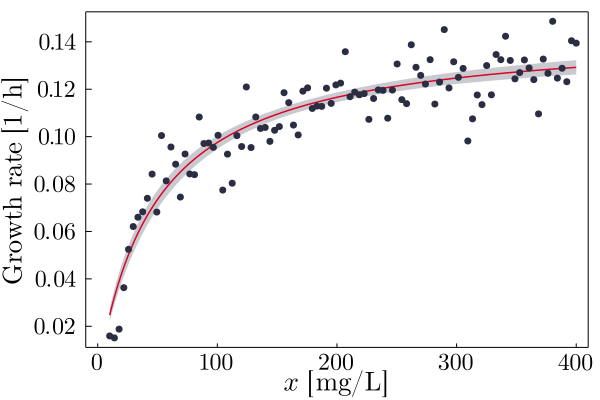

In [16]:
y_fit = monod_fun(q_OLS,x₀)

p1 = plot(x₀,lo_bounds_cred; fillrange=up_bounds_cred,fillcolor=colorant"#2b2d42", fillalpha=0.25, linealpha=0.0, label=:none,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          )
p1 = plot!(x₀,y_fit;label=:none,
#      label=L"\textrm{Estimation of mean response }\hat{\Upsilon}_{x_0}\left(\mathbf{q}_{OLS}\right)",
     lw=1.5,lc=colorant"#d90429",legend=:bottomright,
     boxstyle=:frame, xlabel=L"x\;\,[\mathrm{mg}/\mathrm{L}]",ylabel=L"\textrm{Growth rate}\;\,[1/\mathrm{h}]",)
p1 = scatter!(x,y_obs;
#     label=L"\textrm{Observational data }\upsilon_{obs}",
            markercolor=colorant"#2b2d42", markerstrokecolor=colorant"#2b2d42",
            xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,grid=:none,label=:none,
            xlim=(-10,410),
            yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,framestyle=:box,
            xticks = ([0,100,200,300,400],[L"0",L"100",L"200",L"300",L"400"]),
            yticks = ([0.02,0.04,0.06,0.08,0.1,0.12,0.14],[L"0.02",L"0.04", L"0.06",L"0.08",L"0.10",L"0.12",L"0.14"])
)
plot(p1)

The dots denote the observational data $\upsilon_{\mathrm{obs}}$ that we used to estimate the OLS estimates for $q_{1_{\mathrm{OLS}}}$ and $q_{2_{\mathrm{OLS}}}$. The red line illustrates the estimate of the mean response $\hat{\Upsilon}_{x_0}\left(\mathbf{q}_{\mathrm{OLS}}\right)$. The grey shaded area shows the confidence intervals for the prediction of the mean responses $\mu_{x_0} = \mathrm{E}[\Upsilon_{x_0}]$.

Now we want to consider the construction of interval estimates for the prediction of a new observation $\Upsilon_{x_0}$. We refer to [Nonlinear Regression - pp. 193-194](http://www.ru.ac.bd/wp-content/uploads/sites/25/2019/03/304_11_Seber_Nonlinear-Regression-2003.pdf) for more information on the construction of **prediction intervals** for nonlinear functions.
Recall that true new measurements would be given by

\begin{align}
\Upsilon_{x_0} = f(x_0, q_0) + \varepsilon_{x_0},
\end{align}

where $\varepsilon_{x_0}$ is i.i.d. and normal distributed, i.e. $\varepsilon_{x_0} \sim \mathcal{N}(0,\sigma^2)$.
We assume that for a large total number of observations $n$ the OLS estimate $q_{\mathrm{OLS}}$ is near to the true unknown but fixed value $q_0$. Such that, we consider the first-order Taylor expansion, i.e.

\begin{align}
f(x_0, q_{\mathrm{OLS}}) \approx f(x_0, q_0) + \nabla f(x_0, q_0) (q_{\mathrm{OLS}}-q_0).
\end{align}

Therefore

\begin{align}
\Upsilon_{x_0}(q_o) - \hat{\Upsilon}_{x_0}(q_{\mathrm{OLS}}) &\approx \Upsilon_{x_0}(q_o) - f(x_0, q_0) - \nabla f(x_0, q_0) (q_{\mathrm{OLS}}-q_0)\\
&\approx \varepsilon_{x_0} - \nabla f(x_0, q_0) (q_{\mathrm{OLS}}-q_0).
\end{align}

$\Upsilon_{x_0}(q_o) - \hat{\Upsilon}_{x_0}(q_{\mathrm{OLS}})$ is normal distributed with mean 

\begin{align}
\mathrm{E}[\Upsilon_{x_0}(q_o) - \hat{\Upsilon}_{x_0}(q_{\mathrm{OLS}})] \approx 0
\end{align}

and variance (since $\mathrm{Cov}(\varepsilon_{x_0}, q_{\mathrm{OLS}}) = 0$)

\begin{align}
\mathrm{Var}\left(\Upsilon_{x_0}(q_o) - \hat{\Upsilon}_{x_0}(q_{\mathrm{OLS}})\right) &\approx \mathrm{Var}\left(\varepsilon_{x_0}\right) + \mathrm{Var}\left(\nabla f(x_0, q_0) (q_{\mathrm{OLS}}-q_0)\right)\\
&\approx \sigma^2_{\mathrm{OLS}}\left[1 + \nabla f_{x_0}^\intercal(\mathcal{X}^\intercal\mathcal{X})^{-1} \nabla f_{x_0}\right],
\end{align}

which is the sum of the estimate for the measurement error variance and the variance associated with the mean model response.
It follows again that 

\begin{align}
T = \frac{\Upsilon_{x_0}(q_o) - \hat{\Upsilon}_{x_0}(q_{\mathrm{OLS}})}{\left[1 + \nabla f_{x_0}^\intercal(\mathcal{X}^\intercal\mathcal{X})^{-1} \nabla f_{x_0}\right]} \sim t_{n-p}
\end{align}

has a t-distribution with $n-p$ degrees of freedom. Such that an approximated intervals estimator for a new observation $\Upsilon_{x_0}$ is given by

\begin{align}
\left[\hat{\Upsilon}_{x_0} \pm t_{n-p,(1-\alpha)/2} \cdot \sigma_{\mathrm{OLS}}\sqrt{1 + \nabla f_{x_0}^\intercal(\mathcal{X}^\intercal\mathcal{X})^{-1} \nabla f_{x_0}}\,\right],
\end{align}

which is also referred to as **prediction interval**.

In [17]:
# get the confidence interval limits
limits_pred = [getPredictionInterval(xᵢ,q_OLS,σ_OLS,inv_𝒳ᵀ𝒳,t_value) for xᵢ in x₀]
lo_bounds_pred, up_bounds_pred = getindex.(limits_pred,1), getindex.(limits_pred,2);

7 out of 100 observational points lie outside the 95% prediction interval.


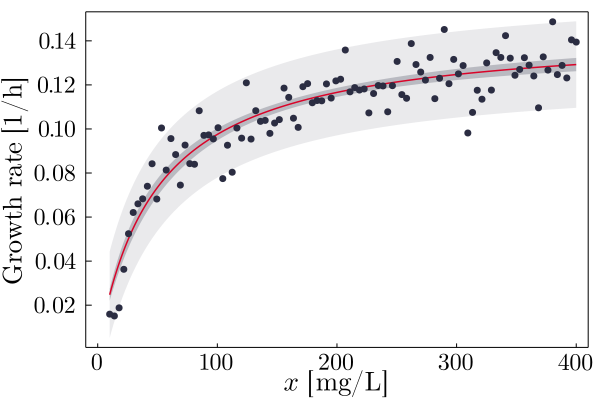

In [18]:
x₀ = collect(10:0.1:400) # more points for fitted model solution
y_fit = monod_fun(q_OLS,x₀)#

# Prediction interval
p1 = plot(x₀,lo_bounds_pred; fillrange=up_bounds_pred,fillcolor=colorant"#2b2d42", fillalpha=0.1, linealpha=0.0, label=:none,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          )

# Confidence interval
p1 = plot!(x₀,lo_bounds_cred; fillrange=up_bounds_cred,fillcolor=colorant"#2b2d42", fillalpha=0.25, linealpha=0.0, label=:none,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          )

# mean estimate
p1 = plot!(x₀,y_fit;label=:none,
#      label=L"\textrm{Estimation of mean response }\hat{\Upsilon}_{x_0}\left(\mathbf{q}_{OLS}\right)",
     lw=1.5,lc=colorant"#d90429",legend=:bottomright,
     boxstyle=:frame, xlabel=L"x\;\,[\mathrm{mg}/\mathrm{L}]",ylabel=L"\textrm{Growth rate}\;\,[1/\mathrm{h}]",)

# measurements
p1 = scatter!(x,y_obs;
#     label=L"\textrm{Observational data }\upsilon_{obs}",
            markercolor=colorant"#2b2d42", markerstrokecolor=colorant"#2b2d42",
            xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,grid=:none,label=:none,
            xlim=(-10,410),
            yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,framestyle=:box,
            xticks = ([0,100,200,300,400],[L"0",L"100",L"200",L"300",L"400"]),
            yticks = ([0.02,0.04,0.06,0.08,0.1,0.12,0.14],[L"0.02",L"0.04", L"0.06",L"0.08",L"0.10",L"0.12",L"0.14"])
)

# count how many data points lie outside the 95% prediction interval
# we need to interpolate to check how many measurements lie within the prediction interval
interp_lo_bound_pred = LinearInterpolation(x₀, lo_bounds_pred)
interp_up_bound_pred = LinearInterpolation(x₀, up_bounds_pred)
counter = 0
for (i, yᵢ) in enumerate(y_obs)
    if (yᵢ > interp_up_bound_pred(x[i])) || (yᵢ < interp_lo_bound_pred(x[i]))
        counter += 1
    end
end

println("$(counter) out of $(length(y_obs)) observational points lie outside the 95% prediction interval.")
plot(p1)

The prediction interval is the sum of the uncertainty in estimating the mean response (confidence interval) and the measurement errors. The interpretation of the prediction interval is similar to the interpretation of the confidence intervals. If we would repeat the estimation process for $N$ data sets, where each record contains $n$ observations, then the associated $95\%$ prediction interval estimates would contain on average $95 N$ of the single future observations. (Note that we constructed an individual confidence interval and prediction interval estimate for each point in $x_0$)

## Uncertainty Quantification of the model response using the information about the input uncertainties obtained by bayesian parameter estimation
In example 4.1 (02-Parameter-Estimation/01-Parameter-Estimation) we used Bayesian techniques to determine input uncertainties, due to measurement errors.
We can utilize the ensemble of model solutions, which were computed to determine the likelihood function central to the random walk metropolis algorithm, to construct the push-forward uncertainties. In this way we can construct the push-forward distributions without any additional costs. First we load the Markov chains for the parameters $q_1$ and $q_2$ and the corresponding model solutions, which were calculated to determine the likelihood function central to the random walk metropolis algorithm.

In [20]:
data = load("..//02-Parameter-Estimation//data//MC_vals_maginal_paths_and_density.jld2")
acceptance_rate = data["acceptance_rate"]
q₁_MC_vals, q₂_MC_vals = data["q1_MC_vals"], data["q2_MC_vals"];
q₁_MC_burn_in, q₂_MC_burn_in = data["q1_MC_burn_in"], data["q2_MC_burn_in"]
sol_MC_burnedin = data["sol_MC_burnedin"];

data = load("..//02-Parameter-Estimation//data//lu_credible_interval.jld2")
l_q₁,u_q₁ = data["bounds_q1"]
l_q₂,u_q₂ = data["bounds_q2"];

# Compute the parameter denstities (posterior density) with the kernel density estimation technique
q₁_MC_density = KernelDensity.kde(q₁_MC_vals,kernel=Normal)
q₂_MC_density = KernelDensity.kde(q₂_MC_vals,kernel=Normal);

We plot the distribution of the uncertain parameters $q_1$ and $q_2$, which were computed in example 4.1 utilizing the random walk metropolis algorithm.

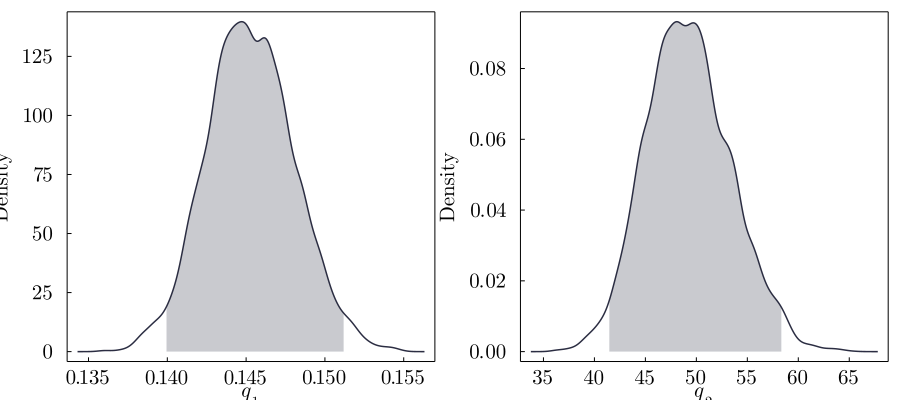

In [229]:
# transform univariatekde in 2D array
kde_dens_q₁ = hcat(q₁_MC_density.x,q₁_MC_density.density)
kde_dens_q₂ = hcat(q₂_MC_density.x,q₂_MC_density.density) 
# get the array elements within credible interval
cred_q₁ = kde_dens_q₁[(l_q₁.<=kde_dens_q₁[:,1]).&(kde_dens_q₁[:,1].<=u_q₁),:]
cred_q₂ = kde_dens_q₂[(l_q₂.<=kde_dens_q₂[:,1]).&(kde_dens_q₂[:,1].<=u_q₂),:]
# Plot the posterior denstiy
p1 = plot(q₁_MC_density.x,q₁_MC_density.density;legend=:none,framestyle=:box,grid=:none,lc=colorant"#2b2d42",lw=1.5,xlabel=L"q_1",ylabel=L"\textrm{Density}",
          xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick, yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,legendfontsize=fontsize_legend,
          xticks = ([0.135,0.140,0.145,0.150,0.155],[L"0.135",L"0.140", L"0.145",L"0.150",L"0.155"]),
          yticks = ([0,25,50,75,100,125],[L"0", L"25",L"50",L"75", L"100",L"125"]),
          )
# Fill the area within the credible interval
p1 = plot!(cred_q₁[:,1], zeros(length(cred_q₁[:,1])),fillrange=cred_q₁[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

p2 = plot(q₂_MC_density.x,q₂_MC_density.density;legend=:none,framestyle=:box,grid=:none,lc=colorant"#2b2d42",lw=1.5,xlabel=L"q_2",ylabel=L"\textrm{Density}",
          xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick, yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,legendfontsize=fontsize_legend,
          xticks = ([35,40,45,50,55,60,65],[L"35",L"40",L"45", L"50",L"55",L"60",L"65"]),
          yticks = ([0,0.02,0.04,0.06,0.08],[L"0.00", L"0.02",L"0.04",L"0.06", L"0.08"])
          )
# Fill the area within the credible interval
p2 = plot!(cred_q₂[:,1], zeros(length(cred_q₂[:,1])),fillrange=cred_q₂[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)
plot(p1,p2;size=(900,400))

We now propagate these input uncertainties through the model to construct credible intervals and the model response distributions. Recall that we already computed the corresponding ensamble of model responses to compute the likelihood in the random walk metropolis algorithm. Consequently we can construct the credible intervals and the distribution for specific model responses $\Upsilon_{i}$ without any additional model evaluations.

In [82]:
n = size(sol_MC_burnedin,2)::Int # total number of equal distant points in x
arr_ResponseCred = Array{CredIntervalStats,1}(undef, n) # intialize an array that save the Julia Types which contain the information to plot the credible intervals
for i in 1:n
    xᵢ = x[i]
    lb_credᵢ = StatsBase.quantile(sol_MC_burnedin[:,i],0.025)
    up_credᵢ = StatsBase.quantile(sol_MC_burnedin[:,i],0.975)
    kdeᵢ = KernelDensity.kde(sol_MC_burnedin[:,i])
    credElementsᵢ = getCredElements(kdeᵢ,sol_MC_burnedin[:,i],lb_credᵢ, up_credᵢ)
    arr_ResponseCred[i] = CredIntervalStats(xᵢ,lb_credᵢ,up_credᵢ,kdeᵢ,credElementsᵢ)
end
modelresponse_mean = StatsBase.mean(sol_MC_burnedin,dims=1)';

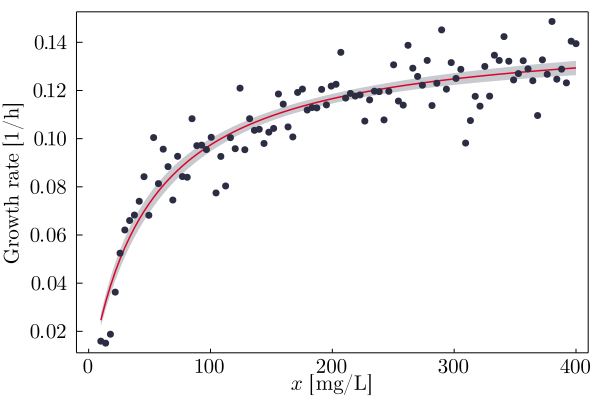

In [174]:
# p1 = plot!(x, sol_MC_burnedin[1000:1100,:]',lw=0.5,ls=:dash,label=:none, xlim=(30,150),ylim=(0.06,0.1),)

# Credible interval
p1 = plot(x,[arr_ResponseCred[i].lb_cred for i in 1:n]; fillrange=[arr_ResponseCred[i].up_cred for i in 1:n],fillcolor=colorant"#2b2d42", fillalpha=0.25, linealpha=0.0, label=:none,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          )

# mean estimate
p1 = plot!(x,modelresponse_mean;label=:none,
#      label=L"\textrm{Estimation of mean response }\hat{\Upsilon}_{x_0}\left(\mathbf{q}_{OLS}\right)",
     lw=1.5,lc=colorant"#d90429",legend=:bottomright,
     boxstyle=:frame, xlabel=L"x\;\,[\mathrm{mg}/\mathrm{L}]",ylabel=L"\textrm{Growth rate}\;\,[1/\mathrm{h}]",)

# measurements
p1 = scatter!(x,y_obs;
#     label=L"\textrm{Observational data }\upsilon_{obs}",
            markercolor=colorant"#2b2d42", markerstrokecolor=colorant"#2b2d42",
            xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,grid=:none,label=:none,
            xlim=(-10,410),
            yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,framestyle=:box,
            xticks = ([0,100,200,300,400],[L"0",L"100",L"200",L"300",L"400"]),
            yticks = ([0.02,0.04,0.06,0.08,0.1,0.12,0.14],[L"0.02",L"0.04", L"0.06",L"0.08",L"0.10",L"0.12",L"0.14"])
)

The grey shaded area illustrates the $95\%$ credible intervals, which can be interpreted as a measure of the model fit. The $95\%$ credible intervals assume that $95\%$ of the model solutions for a specific $x$, calculated taking into account the uncertain input parameters, lie within the credible intervals. The confidence interval and the credible interval agree with each other and are both symmeteric w.r.t. to the point estimates ($\mathrm{E}[\Upsilon_i]$). However, this is only the case because we have gaussian response distribution. In general, the Bayesian approach also allows the quantification of asymmetric non-gaussian response distributions for non-linear models with potentially non-Gaussian distributions of the input parameters, which is not possible with the discussed frequentist approach.

We consider different QoIs $\mathcal{G_{\ell}} = \mathcal{O}_{\ell} \circ G,\; \ell = 1,2,3$. 
Where the operators $\mathcal{O}_{\ell},\;\ell=1,2,3$ stand for the growth rate at three different concentrations of the subtrates, i.e. $x=140$, $x=270$ and $x=400\,[\mathrm{mg}/\mathrm{L}]$. 

		Statistics for the QoIs
	 μ 		 σ 		 skewness 	 kurtosis
𝒢₁ 	 0.1075 	 0.00108 	 0.04 		 -0.02
𝒢₂ 	 0.12288 	 0.00117 	 -0.01 		 0.03
𝒢₃ 	 0.12936 	 0.0015 	 0.0 		 0.03

	 Check the percentage of realizations of the QoIs within the 95% credible intervals
𝒢₁ 	 0.95%
𝒢₂ 	 0.95%
𝒢₃ 	 0.95%


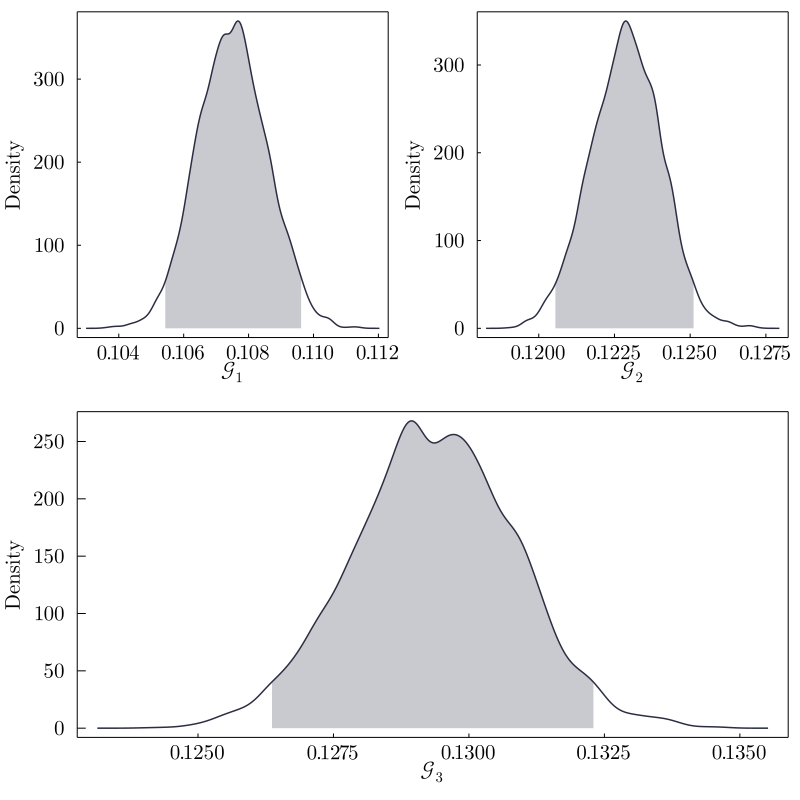

In [247]:
# Assign the kerneldensity esimtates
𝒢₁_kde = arr_ResponseCred[34].kde
𝒢₂_kde = arr_ResponseCred[67].kde
𝒢₃_kde = arr_ResponseCred[100].kde

# Assign the valus of the realizations of the QoIs
𝒢₁_dist = sol_MC_burnedin[:,34]
𝒢₂_dist = sol_MC_burnedin[:,67]
𝒢₃_dist = sol_MC_burnedin[:,100]

# G₁ (x=140)
p1 = plot(arr_ResponseCred[34].kde.x,arr_ResponseCred[34].kde.density;legend=:none,framestyle=:box,grid=:none,lc=colorant"#2b2d42",lw=1.5,xlabel=L"\mathcal{G}_1",ylabel=L"\textrm{Density}",
          xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick, yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,legendfontsize=fontsize_legend,
          xticks = ([0.104,0.106,0.108,0.110,0.112],[L"0.104",L"0.106",L"0.108",L"0.110",L"0.112"]),
          yticks = ([0,100,200,300],[L"0",L"100", L"200",L"300"])
)
p1 = plot!(arr_ResponseCred[34].credElements[:,1], zeros(length(arr_ResponseCred[34].credElements[:,1])),fillrange=arr_ResponseCred[34].credElements[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

# G₂ (x=270)
p2 = plot(arr_ResponseCred[67].kde.x,arr_ResponseCred[67].kde.density;legend=:none,framestyle=:box,grid=:none,lc=colorant"#2b2d42",lw=1.5,xlabel=L"\mathcal{G}_2",ylabel=L"\textrm{Density}",
          xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick, yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,legendfontsize=fontsize_legend,
          xticks = ([0.12,0.1225,0.125,0.1275],[L"0.1200",L"0.1225",L"0.1250",L"0.1275"]),
          yticks = ([0,100,200,300],[L"0",L"100", L"200",L"300"])
)
p2 = plot!(arr_ResponseCred[67].credElements[:,1], zeros(length(arr_ResponseCred[67].credElements[:,1])),fillrange=arr_ResponseCred[67].credElements[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

# G₃ (x=400)
p3 = plot(arr_ResponseCred[100].kde.x,arr_ResponseCred[100].kde.density;legend=:none,framestyle=:box,grid=:none,lc=colorant"#2b2d42",lw=1.5,xlabel=L"\mathcal{G}_3",ylabel=L"\textrm{Density}",
          xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick, yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,legendfontsize=fontsize_legend,
          xticks = ([0.125,0.1275,0.130,0.1325,0.1350],[L"0.1250",L"0.1275",L"0.1300",L"0.1325",L"0.1350"]),
          yticks = ([0,50,100,150,200,250],[L"0",L"50", L"100",L"150",L"200",L"250"])
)
p3 = plot!(arr_ResponseCred[100].credElements[:,1], zeros(length(arr_ResponseCred[100].credElements[:,1])),fillrange=arr_ResponseCred[100].credElements[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)

# Get the statistics: mean, standard deviation, skewness, kurtosis
𝒢₁_μ, 𝒢₁_σ, 𝒢₁_skew, 𝒢₁_kurt = getStatistics(𝒢₁_dist)
𝒢₂_μ, 𝒢₂_σ, 𝒢₂_skew, 𝒢₂_kurt = getStatistics(𝒢₂_dist)
𝒢₃_μ, 𝒢₃_σ, 𝒢₃_skew, 𝒢₃_kurt = getStatistics(𝒢₃_dist);

println("\t\tStatistics for the QoIs")
println("\t μ \t\t σ \t\t skewness \t kurtosis")
println("𝒢₁ \t $(𝒢₁_μ) \t $(𝒢₁_σ) \t $(𝒢₁_skew) \t\t $(𝒢₁_kurt)")
println("𝒢₂ \t $(𝒢₂_μ) \t $(𝒢₂_σ) \t $(𝒢₂_skew) \t\t $(𝒢₂_kurt)")
println("𝒢₃ \t $(𝒢₃_μ) \t $(𝒢₃_σ) \t $(𝒢₃_skew) \t\t $(𝒢₃_kurt)")

# Check the percentage of realizations for the QoIs within the credible intervals
perc_𝒢₁ = countPercentageInCred(arr_ResponseCred[34].lb_cred, arr_ResponseCred[34].up_cred, 𝒢₁_dist)
perc_𝒢₂ = countPercentageInCred(arr_ResponseCred[67].lb_cred, arr_ResponseCred[67].up_cred, 𝒢₂_dist)
perc_𝒢₃ = countPercentageInCred(arr_ResponseCred[100].lb_cred, arr_ResponseCred[100].up_cred, 𝒢₃_dist)

println("\n\t Check the percentage of realizations of the QoIs within the 95% credible intervals")
println("𝒢₁ \t $(perc_𝒢₁)%")
println("𝒢₂ \t $(perc_𝒢₂)%")
println("𝒢₃ \t $(perc_𝒢₃)%")

l = @layout [a b; c]
plot(p1, p2, p3, layout=l, size=(800,800))

The figures illustrate the push-forward distribution with the $95\%$ credible interval (shaded area) (using equal-tailed interval method).

In some cases, it is not possible to store the ensamble of all model solutions due to memory limitations. In this case, one can also draw random samples from the burned-in Markov chain indices to calculate realizations of the model and create a density for the model response.

Recall that in the bayesian approach for parameter estimation in example 4.1 we employed the point estimate

\begin{align}
\sigma^2_{\mathrm{OLS}} = \frac{1}{n-p} \sum_{i=1}^n [\upsilon_i - f(x_i,q_{\mathrm{OLS}})]^2
\end{align}

to approximate the unknown measurement error variance. One should note that the measurement error variance could have been treated as an additional random parameter whose density is sampled by realizations of the Markov chain. With the latter approach, the information on measurement error variance could be used to construct Bayesian prediction intervals.

# !!! Other Material not relevant for the Example

In [203]:
a = Animation()

for i in 1:n
    plot(arr_ResponseCred[i].kde.x,arr_ResponseCred[i].kde.density;legend=:none,framestyle=:box,grid=:none,lc=colorant"#2b2d42",lw=1.5,xlabel=L"\Upsilon_{%$(arr_ResponseCred[i].x)}",ylabel=L"\textrm{Density}",
          xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick, yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,legendfontsize=fontsize_legend,
          )
    plot!(arr_ResponseCred[i].credElements[:,1], zeros(length(arr_ResponseCred[i].credElements[:,1])),fillrange=arr_ResponseCred[i].credElements[:,2],fillcolor=colorant"#2b2d42",
     fillalpha=0.25,linealpha=0.0,legend=:none)
    frame(a)
end
gif(a,fps=5);

┌ Info: Saved animation to 
│   fn = D:\Uni\TBM\Module\04_Semester\master-thesis-valentino-golob\00_Code\02_Julia_Code\03-Forward-UQ\tmp.gif
└ @ Plots C:\Users\valen\.julia\packages\Plots\SjqWU\src\animation.jl:104


In some cases, it is not possible to store the ensamble of all model solutions due to memory limitations. In this case, one can also draw random samples from the burned-in Markov chain indices to calculate realizations of the model and create a density for the model response.

Recall that in the bayesian approach for parameter estimation in example 4.1 we employed the estimate

\begin{align}
\sigma^2_{\mathrm{OLS}} = \frac{1}{n-p} \sum_{i=1}^n [\upsilon_i - f(x_i,q_{\mathrm{OLS}})]^2
\end{align}

to approximate the unknown measurement error variance. One should note that the measurement error variance could have been treated as an additional random parameter whose density is sampled by realizations of the Markov chain.